# Importing Packages

In [44]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score, RocCurveDisplay
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt

# Loading Datasets

In [3]:
train_data = pd.read_csv('/content/train_data_v3.csv')
test_data = pd.read_csv('/content/test_data_v3.csv')
validate_data = pd.read_csv('/content/validate_data_v3.csv')

train_data.info()
test_data.info()
validate_data.info()

train_data.head()
test_data.head()
validate_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 69 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Wind_Direction_E                                  8000 non-null   float64
 1   Wind_Direction_ENE                                8000 non-null   float64
 2   Wind_Direction_ESE                                8000 non-null   float64
 3   Wind_Direction_East                               8000 non-null   float64
 4   Wind_Direction_N                                  8000 non-null   float64
 5   Wind_Direction_NE                                 8000 non-null   float64
 6   Wind_Direction_NNE                                8000 non-null   float64
 7   Wind_Direction_NNW                                8000 non-null   float64
 8   Wind_Direction_NW                                 8000 non-null   float64
 9   Wind_Direction_Nort

,Wind_Direction_E,Wind_Direction_ENE,Wind_Direction_ESE,Wind_Direction_East,Wind_Direction_N,Wind_Direction_NE,Wind_Direction_NNE,Wind_Direction_NNW,Wind_Direction_NW,Wind_Direction_North,...,Weather_Condition_Encoded,Weather_Condition_Fog / Low Visibility,Weather_Condition_Others,Weather_Condition_Snow,Weather_Condition_Thunderstorms / Severe Weather,Weather_Year,Weather_Month,Weather_Day,Weather_Hour,Severity
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,2021,1,29,20,2
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,2022,12,5,16,2
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,2020,3,17,14,3
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4,0,0,1,0,2019,2,27,4,3
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,2022,7,30,9,2


# Building Model

## Separate Target and Features

In [6]:
X_train = train_data.drop(columns=['Severity'])
y_train = train_data['Severity']
X_test = test_data.drop(columns=['Severity'])
y_test = test_data['Severity']
X_validate = validate_data.drop(columns=['Severity'])
y_validate = validate_data['Severity']

## Scale Data

In [7]:
# Scale the data before feature selection and model training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_validate_scaled = scaler.transform(X_validate)
X_test_scaled = scaler.transform(X_test)

##SVM Base Model (kernel=rbf)

In [29]:
svm_pipeline = Pipeline([
    ('svm', SVC(kernel='rbf', class_weight='balanced', probability = True))
])

# Define hyperparameter grid
param_grid = {
    'svm__C': [0.1, 1, 5],  # Regularization parameter
    'svm__gamma': ['scale', 'auto', 0.1, 0.01]  # Kernel coefficient
}

In [30]:
# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(svm_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('svm',
                                        SVC(class_weight='balanced',
                                            probability=True))]),
             n_jobs=-1,
             param_grid={'svm__C': [0.1, 1, 5],
                         'svm__gamma': ['scale', 'auto', 0.1, 0.01]},
             scoring='accuracy')

In [31]:
# Get the best model from Grid Search
best_svm = grid_search.best_estimator_

# Predict on validation set (for hyperparameter tuning)
y_validate_pred = best_svm.predict(X_validate_scaled)

# Evaluate performance on validation set
validate_accuracy = accuracy_score(y_validate, y_validate_pred)
validate_report = classification_report(y_validate, y_validate_pred)

# Print results on validation set
print("Validation Accuracy ", validate_accuracy)
print("Classification Report (Validation Set):\n", validate_report)

# Evaluate the best model on the test set
y_test_pred_balanced = best_svm.predict(X_test_scaled)
test_accuracy_balanced = accuracy_score(y_test, y_test_pred_balanced)
test_report_balanced = classification_report(y_test, y_test_pred_balanced)

# Print results
print("Best SVM Model:", grid_search.best_params_)
print("Test Accuracy After Balancing:", test_accuracy_balanced)
print("Classification Report:\n", test_report_balanced)

Validation Accuracy  0.425
Classification Report (Validation Set):
               precision    recall  f1-score   support

           1       0.07      0.86      0.14        14
           2       0.93      0.38      0.54       828
           3       0.31      0.69      0.42       124
           4       0.06      0.41      0.11        34

    accuracy                           0.42      1000
   macro avg       0.34      0.58      0.30      1000
weighted avg       0.81      0.42      0.50      1000

Best SVM Model: {'svm__C': 5, 'svm__gamma': 0.01}
Test Accuracy After Balancing: 0.427
Classification Report:
               precision    recall  f1-score   support

           1       0.03      0.83      0.07         6
           2       0.92      0.41      0.57       857
           3       0.25      0.52      0.34       119
           4       0.04      0.44      0.07        18

    accuracy                           0.43      1000
   macro avg       0.31      0.55      0.26      1000
weight

<Figure size 1000x800 with 0 Axes>

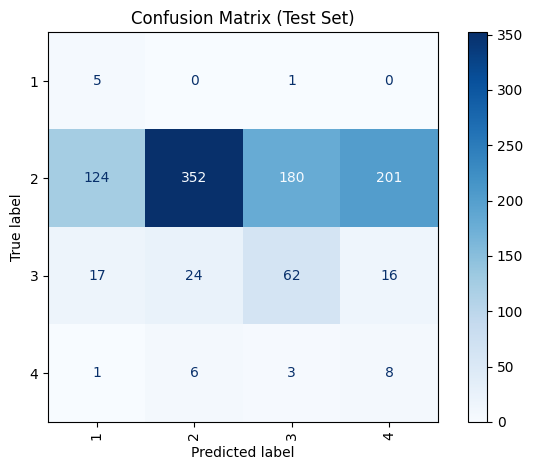

In [32]:
# Confusion Matrix
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay.from_estimator(best_svm, X_test_scaled, y_test,
                                      cmap='Blues',
                                      display_labels=best_svm.classes_,
                                      xticks_rotation='vertical')
plt.title('Confusion Matrix (Test Set)')
plt.tight_layout()
plt.show()

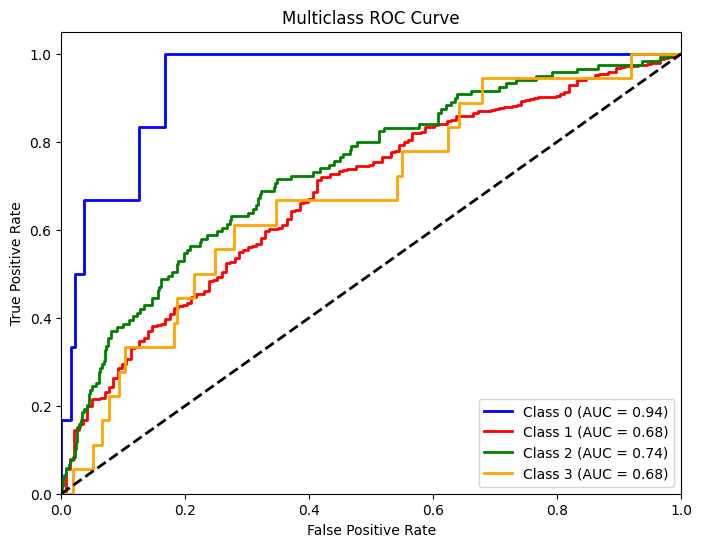

In [34]:
# ROC

# Binarize the true labels for multiclass ROC
n_classes = len(np.unique(y_test))
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

y_test_probs = best_svm.predict_proba(X_test_scaled)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green', 'orange']  # Add more colors if needed

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc="lower right")
plt.show()

## SVM 2nd Model (kernel = poly)

In [35]:
svm_pipeline = Pipeline([
    ('svm', SVC(kernel='poly', class_weight='balanced', probability = True))
])

# Define hyperparameter grid
param_grid = {
    'svm__C': [0.1, 1, 10],  # Regularization parameter
    'svm__gamma': ['scale', 'auto', 0.1, 0.01]  # Kernel coefficient
}

In [37]:
# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(svm_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('svm',
                                        SVC(class_weight='balanced',
                                            kernel='poly',
                                            probability=True))]),
             n_jobs=-1,
             param_grid={'svm__C': [0.1, 1, 10],
                         'svm__gamma': ['scale', 'auto', 0.1, 0.01]},
             scoring='accuracy')

In [38]:
# Get the best model from Grid Search
best_svm = grid_search.best_estimator_

# Predict on validation set (for hyperparameter tuning)
y_validate_pred = best_svm.predict(X_validate_scaled)

# Evaluate performance on validation set
validate_accuracy = accuracy_score(y_validate, y_validate_pred)
validate_report = classification_report(y_validate, y_validate_pred)

# Print results on validation set
print("Validation Accuracy ", validate_accuracy)
print("Classification Report (Validation Set):\n", validate_report)

# Evaluate the best model on the test set
y_test_pred_balanced = best_svm.predict(X_test_scaled)
test_accuracy_balanced = accuracy_score(y_test, y_test_pred_balanced)
test_report_balanced = classification_report(y_test, y_test_pred_balanced)

# Print results
print("Best SVM Model:", grid_search.best_params_)
print("Test Accuracy After Balancing:", test_accuracy_balanced)
print("Classification Report:\n", test_report_balanced)

Validation Accuracy  0.362
Classification Report (Validation Set):
               precision    recall  f1-score   support

           1       0.06      0.86      0.12        14
           2       0.91      0.33      0.48       828
           3       0.27      0.52      0.36       124
           4       0.05      0.44      0.10        34

    accuracy                           0.36      1000
   macro avg       0.33      0.54      0.26      1000
weighted avg       0.79      0.36      0.45      1000

Best SVM Model: {'svm__C': 10, 'svm__gamma': 0.01}
Test Accuracy After Balancing: 0.356
Classification Report:
               precision    recall  f1-score   support

           1       0.02      0.67      0.04         6
           2       0.92      0.34      0.49       857
           3       0.25      0.46      0.32       119
           4       0.03      0.50      0.06        18

    accuracy                           0.36      1000
   macro avg       0.30      0.49      0.23      1000
weigh

<Figure size 1000x800 with 0 Axes>

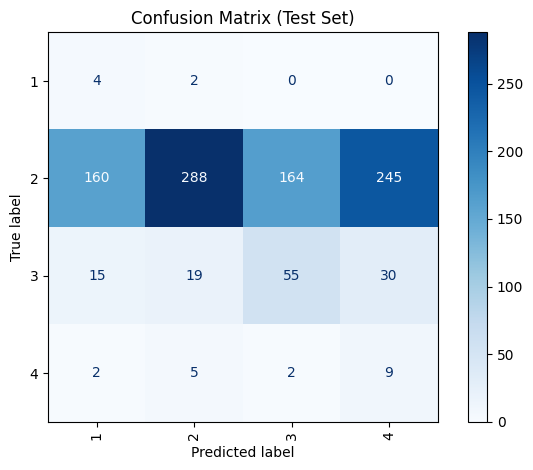

In [39]:
# Confusion Matrix
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay.from_estimator(best_svm, X_test_scaled, y_test,
                                      cmap='Blues',
                                      display_labels=best_svm.classes_,
                                      xticks_rotation='vertical')
plt.title('Confusion Matrix (Test Set)')
plt.tight_layout()
plt.show()

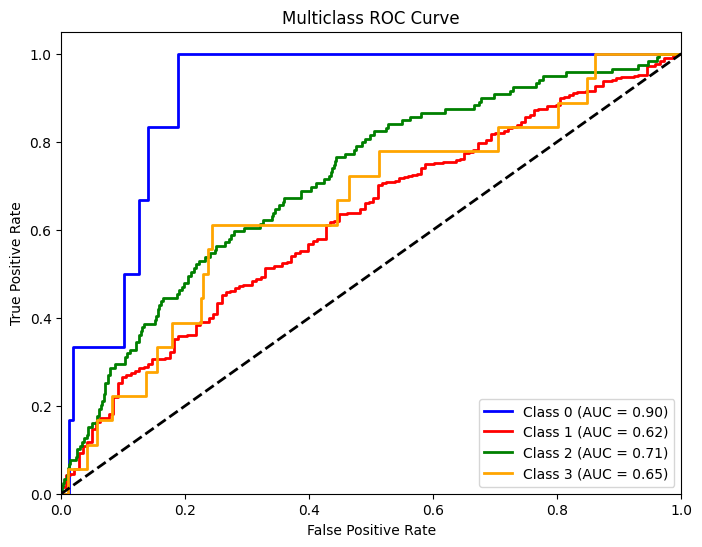

In [40]:
# ROC

# Binarize the true labels for multiclass ROC
n_classes = len(np.unique(y_test))
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

y_test_probs = best_svm.predict_proba(X_test_scaled)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green', 'orange']  # Add more colors if needed

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Linear SVM with RFE

In [41]:
# SVM with RFE (Recursive Feature Elimination)
linear_svm = LinearSVC(C=1, max_iter=5000, class_weight='balanced')
rfe = RFE(estimator=linear_svm, n_features_to_select=20, step=1)  # Keep top 20 features
rfe.fit(X_train_scaled, y_train)

# Get the ranking of features and selected features
selected_features = rfe.support_
X_train_rfe = X_train_scaled[:, selected_features]
X_validate_rfe = X_validate_scaled[:, selected_features]
X_test_rfe = X_test_scaled[:, selected_features]

# Train SVM on selected features
svm_rfe = SVC(kernel='rbf', C=10, gamma=0.1, class_weight='balanced', probability = True)
svm_rfe.fit(X_train_rfe, y_train)

# Predict on validation set (for hyperparameter tuning)
y_validate_pred_rfe = svm_rfe.predict(X_validate_rfe)

# Evaluate performance on validation set
validate_accuracy_rfe = accuracy_score(y_validate, y_validate_pred_rfe)
validate_report_rfe = classification_report(y_validate, y_validate_pred_rfe)

# Print RFE results on validation set
print("Validation Accuracy After RFE:", validate_accuracy_rfe)
print("Classification Report After RFE (Validation Set):\n", validate_report_rfe)

# Hyperparameter tuning on selected features (optional)
# Use GridSearchCV to tune hyperparameters after feature selection
param_grid_rfe = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'gamma': ['scale', 'auto', 0.1, 0.01]  # Kernel coefficient
}

grid_search_rfe = GridSearchCV(svm_rfe, param_grid_rfe, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_rfe.fit(X_train_rfe, y_train)

# Get the best SVM model after feature selection
best_svm_rfe = grid_search_rfe.best_estimator_

# Evaluate the final model on the test set
y_test_pred_rfe = best_svm_rfe.predict(X_test_rfe)

# Evaluate performance on the test set
accuracy_rfe = accuracy_score(y_test, y_test_pred_rfe)
report_rfe = classification_report(y_test, y_test_pred_rfe)

# Print final results
print("Best SVM Model After RFE and Hyperparameter Tuning:", grid_search_rfe.best_params_)
print("Test Accuracy After RFE and Hyperparameter Tuning:", accuracy_rfe)
print("Classification Report After RFE (Test Set):\n", report_rfe)

Validation Accuracy After RFE: 0.474
Classification Report After RFE (Validation Set):
               precision    recall  f1-score   support

           1       0.10      0.86      0.17        14
           2       0.94      0.43      0.59       828
           3       0.29      0.68      0.41       124
           4       0.09      0.56      0.16        34

    accuracy                           0.47      1000
   macro avg       0.35      0.63      0.33      1000
weighted avg       0.82      0.47      0.55      1000

Best SVM Model After RFE and Hyperparameter Tuning: {'C': 10, 'gamma': 'scale'}
Test Accuracy After RFE and Hyperparameter Tuning: 0.443
Classification Report After RFE (Test Set):
               precision    recall  f1-score   support

           1       0.05      1.00      0.10         6
           2       0.94      0.42      0.58       857
           3       0.25      0.60      0.35       119
           4       0.04      0.50      0.08        18

    accuracy           

<Figure size 1000x800 with 0 Axes>

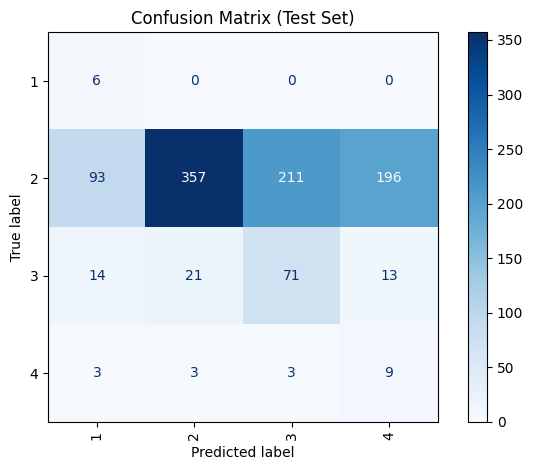

In [42]:
# Confusion Matrix
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay.from_estimator(best_svm_rfe, X_test_rfe, y_test,
                                         cmap='Blues',
                                         display_labels=best_svm_rfe.classes_,
                                         xticks_rotation='vertical')
plt.title('Confusion Matrix (Test Set)')
plt.tight_layout()
plt.show()

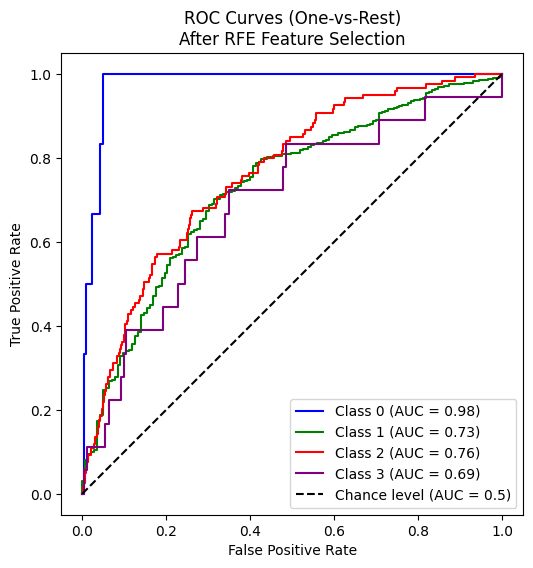

In [45]:
# ROC
y_test_probs = best_svm_rfe.predict_proba(X_test_rfe)

# For multiclass: Binarize labels
n_classes = len(np.unique(y_test))
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

# Plot ROC curves
plt.figure(figsize=(8, 6))
colors = ['blue', 'green', 'red', 'purple']  # Adjust for number of classes

for class_id in range(n_classes):
    RocCurveDisplay.from_predictions(
        y_test_bin[:, class_id],
        y_test_probs[:, class_id],
        name=f"Class {class_id}",
        color=colors[class_id],
        ax=plt.gca()
    )

plt.plot([0, 1], [0, 1], "k--", label="Chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest)\nAfter RFE Feature Selection")
plt.legend(loc="lower right")
plt.show()